# DA Challenges 1
   * Given site user data, want 
        * 1. predict conversion rate
        * 2. come up with recommandations(product/marketing) to improve conversion rate

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
%matplotlib inline

In [13]:
df = pd.read_csv('conversion_data.csv')

In [14]:
# preview
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [16]:
# check null/na
df[df.isnull().any(axis = 1)]
#df[df.isna().any(axis = 1)]

,country,age,new_user,source,total_pages_visited,converted


## 1. Exploratory
   * Take a look at the correlation between each column with the conversion rate 
       * Country
       * Age
       * New User
       * Source
       * Usage

### 1.1 Country

In [17]:
tmp = df.groupby('country').agg({'converted':np.sum, 'country':np.size})
tmp.assign(perc = tmp['converted']/tmp['country'], one_basis_inc = tmp['country']*0.0001)

,converted,country,perc,one_basis_inc
country,,,,
China,102,76602,0.001332,7.6602
Germany,816,13056,0.062500,1.3056
UK,2550,48450,0.052632,4.8450
US,6732,178092,0.037801,17.8092


#### Summary
* Conversion rate descends by the order of Germany, UK, US and China
* US has highest convertions and visits, followed by UK, Germany and China
* Per basis point of conversion rate increase, US brings highest conversion, followed by China, UK, Germany.
* From the statement above, we should focus on US market, and also there is huge growth oppurtunity in China

### 1.2 Age

In [18]:
tmp = df.groupby('age').agg({'converted':np.sum, 'age':np.size})

C:\Python36\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


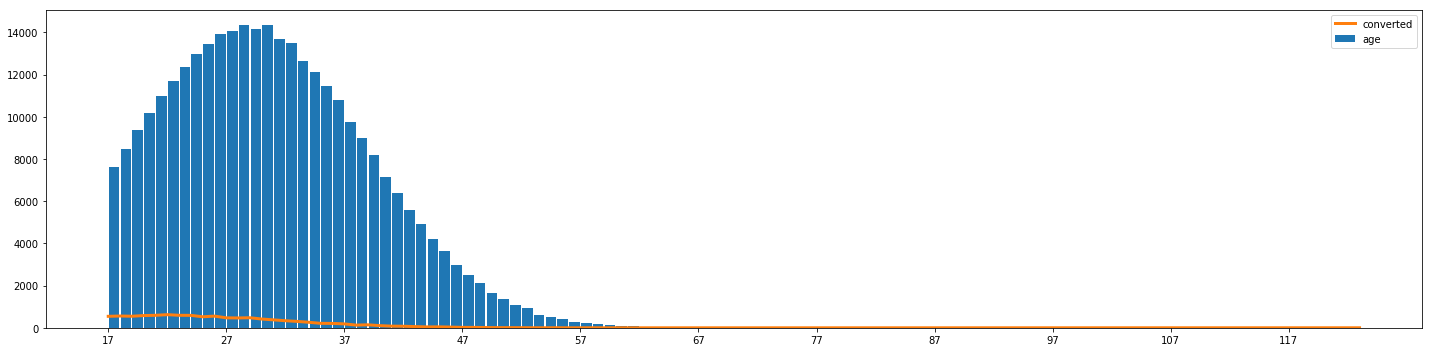

In [19]:
# plot the histgram for age
nbin = df['age'].max() -  df['age'].min()
fig, axs = plt.subplots(figsize=(20, 5), tight_layout=True)
n, bins, patch = axs.hist(df['age'], bins = nbin, rwidth=0.9)
# set ticker
_ = axs.xaxis.set_ticks(np.arange(df['age'].min(), df['age'].max(), 10))
# add convertion 
axs.plot(tmp['converted'], linewidth = 3)
axs.legend()

#### Summary
* Our biggest user group are around age 28-30  
* Convertion are at similar level from age 17 through 25, and it starts to decrease as age increases 
* Younger user tend to have higher convertion rate

### 1.3 New user

In [20]:
tmp = df.groupby('new_user').agg({'new_user':np.size, 'converted':np.sum})
tmp['prec'] = tmp['converted']/tmp['new_user']

In [21]:
tmp

,new_user,converted,prec
new_user,,,
0,99456,7161,0.072002
1,216744,3039,0.014021


#### Summary
* new users are about twice the size of return users
* return users has significant higher conversion rate than new users

### 1.4 Source

In [22]:
tmp = df.groupby('source').agg({'source':np.size, 'converted':np.sum})
tmp['prec'] = tmp['converted']/tmp['source']
tmp

,source,converted,prec
source,,,
Ads,88740,3060,0.034483
Direct,72420,2040,0.028169
Seo,155040,5100,0.032895


#### Summary
* Seo brings the most volume and has decent conversion rate
* Ads and Direct have similar volume, but Ads obvious can aim for better target, so it has highest conversion rate of all

### 1.5 Page visited

In [23]:
tmp = df.groupby('total_pages_visited').agg({'total_pages_visited':np.size, 'converted':np.sum})
tmp['perc'] = tmp['converted']/tmp['total_pages_visited']
tmp

,total_pages_visited,converted,perc
total_pages_visited,,,
1,40739,0,0.000000
2,43868,10,0.000228
3,43829,11,0.000251
4,41046,32,0.000780
5,36308,57,0.001570
6,30261,104,0.003437
7,23488,159,0.006769
8,17522,267,0.015238
9,12157,402,0.033067


#### Summary
* The more users stay at the website, the higher chance they will pay for the service
* We need to increase the user stickiness

## 2. Model
   * Predict convertion based on given data
       * Country
       * Age
       * New User
       * Source
       * Usage

In [24]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from C:\Python36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\hjwyz\AppData\Local\Temp\tmp83k8vqac
  JVM stdout: C:\Users\hjwyz\AppData\Local\Temp\tmp83k8vqac\h2o_hjwyz_started_from_python.out
  JVM stderr: C:\Users\hjwyz\AppData\Local\Temp\tmp83k8vqac\h2o_hjwyz_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_hjwyz_ga8d5o
H2O cluster total nodes:,1
H2O cluster free memory:,1.771 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [55]:
hf = h2o.H2OFrame(df)
hf['country'] = hf['country'].asfactor()
hf['new_user'] = hf['new_user'].asfactor()
hf['source'] = hf['source'].asfactor()
hf['converted'] = hf['converted'].asfactor()
train, validate= hf.split_frame([0.8])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_v1",
    mtries = -1,
    ntrees=200,
    max_depth = 50,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [57]:
x = hf.col_names[:-1]
y = hf.col_names[-1]
rf_v1.train(x, y, training_frame=train, validation_frame=validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [58]:
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.012040649238102656
RMSE: 0.10972989218122223
LogLoss: 0.06788484831144681
Mean Per-Class Error: 0.07479480790719628
AUC: 0.9648509059676847
pr_auc: 0.6246069228804253
Gini: 0.9297018119353695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42150773331852565: 


,0,1,Error,Rate
0,243343.0,1457.0,0.006,(1457.0/244800.0)
1,2394.0,5748.0,0.294,(2394.0/8142.0)
Total,245737.0,7205.0,0.0152,(3851.0/252942.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4215077,0.7490715,168.0
max f2,0.1405621,0.7646965,265.0
max f0point5,0.6533776,0.8066458,106.0
max accuracy,0.5336939,0.9851112,138.0
max precision,0.9937513,0.9690033,5.0
max recall,0.0000076,1.0,399.0
max specificity,0.9999879,0.9998039,0.0
max absolute_mcc,0.4487446,0.7431915,160.0
max min_per_class_accuracy,0.0178836,0.9211496,352.0
max mean_per_class_accuracy,0.0304987,0.9252052,336.0


Gains/Lift Table: Avg response rate:  3.22 %, avg score:  3.22 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100770,0.9822035,29.9511921,29.9511921,0.9642997,0.9968905,0.9642997,0.9968905,0.3018173,0.3018173,2895.1192097,2895.1192097
,2,0.0200037,0.7415216,25.8895550,27.9356247,0.8335325,0.8875709,0.8994071,0.9426412,0.2569990,0.5588163,2488.9554966,2693.5624738
,3,0.0300016,0.3731919,16.2116482,24.0286625,0.5219454,0.5506126,0.7736197,0.8119994,0.1620825,0.7208988,1521.1648221,2302.8662475
,4,0.0400074,0.1848740,7.7435353,19.9557715,0.2493086,0.2634290,0.6424901,0.6748026,0.0774804,0.7983792,674.3535319,1895.5771484
,5,0.0500014,0.1057307,4.5091124,16.8683937,0.1451741,0.1393371,0.5430898,0.5677772,0.0450639,0.8434430,350.9112430,1586.8393710
,6,0.1000028,0.0200953,1.4734366,9.1709152,0.0474383,0.0466256,0.2952641,0.3072014,0.0736739,0.9171169,47.3436632,817.0915171
,7,0.1500002,0.0077520,0.4494337,6.2639079,0.0144698,0.0124538,0.2016709,0.2089574,0.0224705,0.9395874,-55.0566293,526.3907921
,8,0.2000648,0.0038595,0.2526204,4.7596309,0.0081333,0.0054984,0.1532397,0.1580434,0.0126473,0.9522348,-74.7379615,375.9630937
,9,0.3000755,0.0016453,0.1276877,3.2158736,0.0041110,0.0024582,0.1035373,0.1061892,0.0127701,0.9650049,-87.2312254,221.5873624
,10,0.4000466,0.0010470,0.0589561,2.4269640,0.0018981,0.0013088,0.0781378,0.0799797,0.0058939,0.9708988,-94.1043890,142.6964015




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.011986115627413616
RMSE: 0.10948111995871077
LogLoss: 0.047108720474344674
Mean Per-Class Error: 0.0717884636527828
AUC: 0.9782052665103531
pr_auc: 0.7829429926671276
Gini: 0.9564105330207062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34789320554422304: 


,0,1,Error,Rate
0,60724.0,467.0,0.0076,(467.0/61191.0)
1,544.0,1512.0,0.2646,(544.0/2056.0)
Total,61268.0,1979.0,0.016,(1011.0/63247.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3478932,0.7494424,182.0
max f2,0.1360828,0.7740022,258.0
max f0point5,0.6740063,0.8106501,101.0
max accuracy,0.4806089,0.9849795,147.0
max precision,0.9998887,1.0,0.0
max recall,0.0002090,1.0,398.0
max specificity,0.9998887,1.0,0.0
max absolute_mcc,0.4806089,0.7425038,147.0
max min_per_class_accuracy,0.0197842,0.9265564,341.0
max mean_per_class_accuracy,0.0278425,0.9282115,331.0


Gains/Lift Table: Avg response rate:  3.25 %, avg score:  3.24 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100084,0.9814535,30.0331984,30.0331984,0.9763033,0.9936804,0.9763033,0.9936804,0.3005837,0.3005837,2903.3198407,2903.3198407
,2,0.0200009,0.7322810,25.4566605,27.7467384,0.8275316,0.8896979,0.9019763,0.9417302,0.2543774,0.5549611,2445.6660500,2674.6738361
,3,0.0300093,0.3783670,16.3287292,23.9387300,0.5308057,0.5495671,0.7781876,0.8109403,0.1634241,0.7183852,1532.8729231,2293.8730048
,4,0.0400177,0.1903113,8.6503387,20.1151221,0.2812006,0.2726933,0.6538917,0.6763254,0.0865759,0.8049611,765.0338700,1911.5122097
,5,0.0500261,0.1090109,4.5681564,17.0047462,0.1484992,0.1457801,0.5527813,0.5701828,0.0457198,0.8506809,356.8156392,1600.4746215
,6,0.1001312,0.0196370,1.4852037,9.2388485,0.0482802,0.0467950,0.3003316,0.3082823,0.0744163,0.9250973,48.5203663,823.8848481
,7,0.1506475,0.0076794,0.5584367,6.3280681,0.0181534,0.0119214,0.2057095,0.2089044,0.0282101,0.9533074,-44.1563301,532.8068082
,8,0.2001360,0.0038099,0.2653605,4.8289154,0.0086262,0.0050541,0.1569758,0.1584974,0.0131323,0.9664397,-73.4639518,382.8915389
,9,0.3008522,0.0016322,0.1931690,3.2770074,0.0062794,0.0024137,0.1065272,0.1062453,0.0194553,0.9858949,-80.6831023,227.7007430
,10,0.4003036,0.0011143,0.0537971,2.4762336,0.0017488,0.0013317,0.0804961,0.0801806,0.0053502,0.9912451,-94.6202901,147.6233554



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-19 23:26:42,0.021 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-04-19 23:26:42,0.164 sec,1.0,0.1182672,0.2196159,0.9088654,0.4094470,24.6060090,0.0162141,0.1182878,0.2177205,0.9138820,0.4191372,26.0512005,0.0160008
,2019-04-19 23:26:42,0.309 sec,2.0,0.1173605,0.2233653,0.9069109,0.3674464,27.4150008,0.0167331,0.1135250,0.1406136,0.9314734,0.5054036,27.9060077,0.0165225
,2019-04-19 23:26:42,0.492 sec,3.0,0.1161602,0.2057498,0.9146910,0.3795056,27.1982060,0.0164156,0.1124271,0.1148836,0.9434778,0.5477664,28.9438895,0.0158110
,2019-04-19 23:26:42,0.691 sec,4.0,0.1151482,0.1810633,0.9149036,0.3844761,27.6112506,0.0162163,0.1115880,0.0917792,0.9487085,0.5606031,29.1291066,0.0156055
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-04-19 23:26:47,5.435 sec,19.0,0.1098552,0.0736365,0.9623722,0.6119998,29.8828771,0.0153808,0.1095583,0.0481457,0.9775317,0.7791081,30.0422962,0.0155581
,2019-04-19 23:26:47,5.828 sec,20.0,0.1098182,0.0721903,0.9634000,0.6143264,29.9428647,0.0151821,0.1095143,0.0471843,0.9781975,0.7800579,30.0850051,0.0154316
,2019-04-19 23:26:48,6.213 sec,21.0,0.1097579,0.0712836,0.9633810,0.6191230,29.9441879,0.0150791,0.1095159,0.0471600,0.9784055,0.7842904,30.0828689,0.0159375
,2019-04-19 23:26:48,6.606 sec,22.0,0.1097597,0.0700560,0.9643398,0.6209691,29.9425143,0.0151262,0.1095560,0.0471529,0.9784585,0.7820558,30.0377759,0.0157162



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
total_pages_visited,81077.8515625,1.0,0.8393554
age,6166.2607422,0.0760536,0.0638360
new_user,3915.0566406,0.0482876,0.0405305
country,3765.7956543,0.0464467,0.0389853
source,1670.4088135,0.0206025,0.0172928


PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model rf_v1 on column 'country'



country,mean_response,stddev_response,std_error_mean_response
China,0.0094835,0.0691948,0.0002751
Germany,0.0429616,0.1639732,0.0006520
UK,0.0395426,0.1565821,0.0006226
US,0.0343421,0.1453191,0.0005778


PartialDependence: Partial Dependence Plot of model rf_v1 on column 'age'



age,mean_response,stddev_response,std_error_mean_response
17.0,0.0441152,0.1633519,0.0006495
18.7966102,0.0403237,0.1571619,0.0006249
20.5932203,0.0389419,0.1547349,0.0006153
22.3898305,0.0377932,0.1521502,0.0006050
24.1864407,0.0366842,0.1537053,0.0006112
---,---,---,---
115.8135593,0.0699472,0.1203891,0.0004787
117.6101695,0.0699472,0.1203891,0.0004787
119.4067797,0.0699472,0.1203891,0.0004787
121.2033898,0.0699472,0.1203891,0.0004787



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model rf_v1 on column 'new_user'



new_user,mean_response,stddev_response,std_error_mean_response
0,0.0451041,0.1626298,0.0006467
1,0.0233241,0.1228753,0.0004886


PartialDependence: Partial Dependence Plot of model rf_v1 on column 'source'



source,mean_response,stddev_response,std_error_mean_response
Ads,0.0335541,0.1483416,0.0005899
Direct,0.0310448,0.1442073,0.0005734
Seo,0.0322304,0.1437182,0.0005715


PartialDependence: Partial Dependence Plot of model rf_v1 on column 'total_pages_visited'



total_pages_visited,mean_response,stddev_response,std_error_mean_response
1.0,0.0010346,0.0013527,0.0000054
2.0,0.0012671,0.0029454,0.0000117
3.0,0.0011904,0.0021872,0.0000087
4.0,0.0017234,0.0046949,0.0000187
5.0,0.0022357,0.0069794,0.0000278
---,---,---,---
22.0,0.8875169,0.1874837,0.0007455
23.0,0.8875169,0.1874837,0.0007455
24.0,0.8875169,0.1874837,0.0007455
25.0,0.8875169,0.1874837,0.0007455



See the whole table with table.as_data_frame()


[, , , , ]

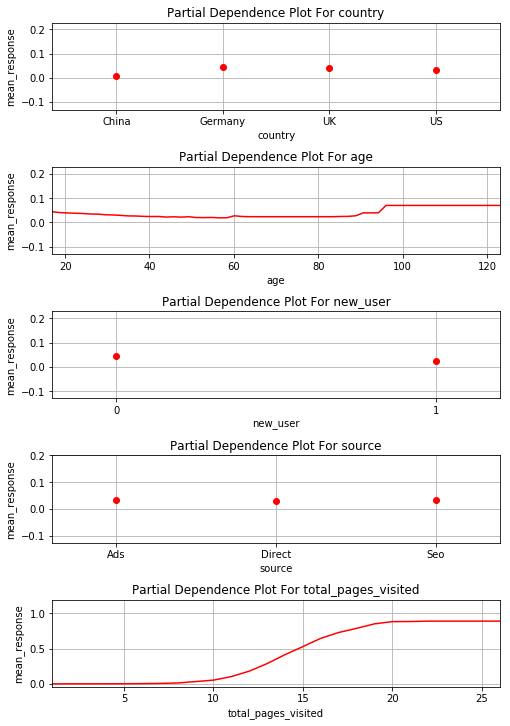

In [59]:
rf_v1.partial_plot(data=validate, cols=x, destination_key=None, nbins=60, weight_column=None,
                     plot=True, plot_stddev = False, figsize=(7, 10), server=False, include_na=False, user_splits=None,
                     save_to_file=None)

In [49]:
rf_v2 = H2ORandomForestEstimator(
    model_id="rf_v2",
    mtries = -1,
    ntrees=200,
    max_depth = 50,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)
x = hf.col_names[:-1]
x.remove('total_pages_visited')
y = hf.col_names[-1]
rf_v2.train(x, y, training_frame=train, validation_frame=validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [50]:
rf_v2.predict(validate).as_data_frame(use_pandas=True)

drf prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1
0,0,0.979990,0.020010
1,0,0.986534,0.013466
2,0,0.961582,0.038418
3,0,0.999822,0.000178
4,0,0.935305,0.064695
5,0,0.988382,0.011618
6,0,0.996745,0.003255
7,0,0.987018,0.012982
8,0,0.999832,0.000168
9,0,0.999191,0.000809


In [51]:
rf_v2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v2


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.029234524761478246
RMSE: 0.17098106550574027
LogLoss: 0.12161316248370603
Mean Per-Class Error: 0.2607846562767877
AUC: 0.813365193552007
pr_auc: 0.12505065114888114
Gini: 0.626730387104014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10268624810856257: 


,0,1,Error,Rate
0,220733.0,20176.0,0.0837,(20176.0/240909.0)
1,4645.0,3313.0,0.5837,(4645.0/7958.0)
Total,225378.0,23489.0,0.0997,(24821.0/248867.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1026862,0.2107037,163.0
max f2,0.0632286,0.3183544,222.0
max f0point5,0.1407539,0.1753932,109.0
max accuracy,0.3557561,0.9680150,0.0
max precision,0.3557561,0.3333333,0.0
max recall,0.0000252,1.0,399.0
max specificity,0.3557561,0.9999834,0.0
max absolute_mcc,0.0638042,0.2049219,221.0
max min_per_class_accuracy,0.0329329,0.7377931,282.0
max mean_per_class_accuracy,0.0326068,0.7392153,283.0


Gains/Lift Table: Avg response rate:  3.20 %, avg score:  3.16 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100071,0.1919192,6.4513999,6.4513999,0.2067194,0.2262966,0.2067194,0.2262966,0.0645599,0.0645599,545.1399891,545.1399891
,2,0.0200538,0.1562628,5.2341803,5.8415897,0.1677165,0.1700852,0.1871795,0.1981354,0.0525861,0.1171460,423.4180285,484.1589674
,3,0.0300016,0.1460239,4.5913091,5.4270273,0.1471173,0.1508232,0.1738958,0.1824479,0.0456734,0.1628194,359.1309077,442.7027287
,4,0.0400008,0.1389201,4.5923890,5.2183883,0.1471519,0.1423909,0.1672105,0.1724346,0.0459203,0.2087397,359.2388969,421.8388341
,5,0.05,0.1321342,4.0245129,4.9796321,0.1289557,0.1355337,0.1595602,0.1650550,0.0402419,0.2489816,302.4512914,397.9632144
,6,0.1,0.0938675,3.5896803,4.2846562,0.1150225,0.1150139,0.1372914,0.1400345,0.1794840,0.4284656,258.9680286,328.4656215
,7,0.1500040,0.0651013,2.3822335,3.6504819,0.0763329,0.0773057,0.1169708,0.1191238,0.1191211,0.5475867,138.2233470,265.0481858
,8,0.2,0.0467798,1.7604158,3.1780027,0.0564082,0.0558256,0.1018313,0.1033005,0.0880138,0.6356005,76.0415771,217.8002716
,9,0.3000040,0.0295445,1.1837576,2.5132368,0.0379306,0.0370294,0.0805305,0.0812096,0.1183804,0.7539810,18.3757646,151.3236831
,10,0.4,0.0205896,0.7826504,2.0806073,0.0250781,0.0245991,0.0666680,0.0670575,0.0782619,0.8322429,-21.7349613,108.0607332




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.030141242252654254
RMSE: 0.17361233323889824
LogLoss: 0.12240473736084964
Mean Per-Class Error: 0.25654830508861315
AUC: 0.8182123634362218
pr_auc: 0.1299306537603038
Gini: 0.6364247268724437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11797434091567993: 


,0,1,Error,Rate
0,57280.0,4001.0,0.0653,(4001.0/61281.0)
1,1360.0,739.0,0.6479,(1360.0/2099.0)
Total,58640.0,4740.0,0.0846,(5361.0/63380.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1179743,0.2161135,84.0
max f2,0.0612629,0.3360750,154.0
max f0point5,0.1499812,0.1815298,52.0
max accuracy,0.2762098,0.9666772,0.0
max precision,0.2424597,0.2456140,9.0
max recall,0.0001717,1.0,398.0
max specificity,0.2762098,0.9997389,0.0
max absolute_mcc,0.0612629,0.2187103,154.0
max min_per_class_accuracy,0.0347868,0.7422582,222.0
max mean_per_class_accuracy,0.0375596,0.7434517,212.0


Gains/Lift Table: Avg response rate:  3.31 %, avg score:  3.23 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106185,0.1919912,6.5056806,6.5056806,0.2154532,0.2212287,0.2154532,0.2212287,0.0690805,0.0690805,550.5680551,550.5680551
,2,0.0208583,0.1514781,4.9782749,5.7558422,0.1648690,0.1635010,0.1906203,0.1928888,0.0509767,0.1200572,397.8274929,475.5842239
,3,0.0318397,0.1469588,4.7288665,5.4016425,0.1566092,0.1491323,0.1788900,0.1777974,0.0519295,0.1719867,372.8866510,440.1642483
,4,0.0405333,0.1374313,4.1648733,5.1363798,0.1379310,0.1411891,0.1701051,0.1699456,0.0362077,0.2081944,316.4873257,413.6379796
,5,0.0520511,0.1333288,4.4672545,4.9883163,0.1479452,0.1349353,0.1652016,0.1621986,0.0514531,0.2596475,346.7254466,398.8316294
,6,0.1,0.0925824,3.5570676,4.3020486,0.1178019,0.1158168,0.1424740,0.1399590,0.1705574,0.4302049,255.7067633,330.2048595
,7,0.1507258,0.0664865,2.7424686,3.7771821,0.0908243,0.0783719,0.1250916,0.1192323,0.1391139,0.5693187,174.2468642,277.7182108
,8,0.2018933,0.0469070,1.7783868,3.2706103,0.0588961,0.0575145,0.1083151,0.1035906,0.0909957,0.6603144,77.8386754,227.0610262
,9,0.3015936,0.0308932,1.1038331,2.5543212,0.0365564,0.0378149,0.0845933,0.0818466,0.1100524,0.7703668,10.3833120,155.4321235
,10,0.4005364,0.0212099,0.7607817,2.1112705,0.0251953,0.0250335,0.0699204,0.0678123,0.0752739,0.8456408,-23.9218256,111.1270492



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-19 23:03:48,0.020 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-04-19 23:03:48,0.111 sec,1.0,0.1708332,0.1245696,0.8130333,0.1241419,4.9696355,0.0924905,0.1736775,0.1284548,0.8110652,0.1309287,6.3349501,0.0988798
,2019-04-19 23:03:49,0.200 sec,2.0,0.1708401,0.1243167,0.8120207,0.1269778,6.5242951,0.0934600,0.1736902,0.1253241,0.8129033,0.1294443,6.5248586,0.0785106
,2019-04-19 23:03:49,0.302 sec,3.0,0.1709400,0.1242962,0.8107067,0.1252127,6.4637353,0.0959738,0.1736632,0.1236738,0.8153730,0.1301056,6.5949241,0.0795677
,2019-04-19 23:03:49,0.435 sec,4.0,0.1708909,0.1241208,0.8093990,0.1234661,6.3715808,0.1036606,0.1736827,0.1228750,0.8147718,0.1292917,6.5299719,0.0956138
,2019-04-19 23:03:49,0.597 sec,5.0,0.1708757,0.1229097,0.8115512,0.1245653,6.4093271,0.1037161,0.1736561,0.1226637,0.8163204,0.1293264,6.3593911,0.0808615
,2019-04-19 23:03:49,0.755 sec,6.0,0.1707977,0.1225760,0.8119796,0.1246747,6.5650131,0.1042631,0.1736320,0.1225426,0.8173038,0.1298089,6.6259347,0.0812559
,2019-04-19 23:03:49,0.914 sec,7.0,0.1709253,0.1226570,0.8120120,0.1244544,6.4513999,0.1017338,0.1736285,0.1225005,0.8177080,0.1297298,6.3519221,0.0816504
,2019-04-19 23:03:49,1.100 sec,8.0,0.1708722,0.1221297,0.8127712,0.1247924,6.5033119,0.1025230,0.1736253,0.1224534,0.8179046,0.1291708,6.5361845,0.0819028
,2019-04-19 23:03:50,1.281 sec,9.0,0.1709811,0.1216132,0.8133652,0.1250507,6.4513999,0.0997360,0.1736123,0.1224047,0.8182124,0.1299307,6.5056806,0.0845850


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
new_user,1521.4649658,1.0,0.4787179
country,883.7348022,0.5808447,0.2780607
age,724.6762695,0.4763016,0.2280141
source,48.3320045,0.0317668,0.0152073


PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model rf_v2 on column 'country'



country,mean_response,stddev_response,std_error_mean_response
China,0.0014237,0.0019092,0.0000076
Germany,0.0591312,0.0660152,0.0002622
UK,0.0508745,0.0533990,0.0002121
US,0.0377445,0.0379058,0.0001506


PartialDependence: Partial Dependence Plot of model rf_v2 on column 'age'



age,mean_response,stddev_response,std_error_mean_response
17,0.0632099,0.0678276,0.0002694
18,0.0610539,0.0659854,0.0002621
19,0.0561315,0.0641211,0.0002547
20,0.0555783,0.0632463,0.0002512
21,0.0535196,0.0565407,0.0002246
---,---,---,---
73,0.0067368,0.0064971,0.0000258
77,0.0067368,0.0064971,0.0000258
79,0.0067368,0.0064971,0.0000258
111,0.0532272,0.0980029,0.0003893



See the whole table with table.as_data_frame()
PartialDependence: Partial Dependence Plot of model rf_v2 on column 'new_user'



new_user,mean_response,stddev_response,std_error_mean_response
0,0.0692837,0.0561501,0.0002230
1,0.0143693,0.0114954,0.0000457


PartialDependence: Partial Dependence Plot of model rf_v2 on column 'source'



source,mean_response,stddev_response,std_error_mean_response
Ads,0.0338130,0.0446978,0.0001775
Direct,0.0287756,0.0371349,0.0001475
Seo,0.0329918,0.0430916,0.0001712


[, , , ]

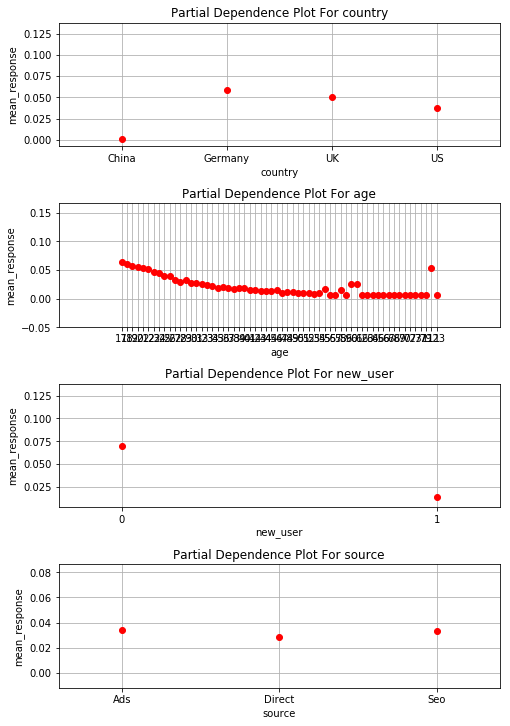

In [52]:
rf_v2.partial_plot(data=validate, cols=x, destination_key=None, nbins=60, weight_column=None,
                     plot=True, plot_stddev = False, figsize=(7, 10), server=False, include_na=False, user_splits=None,
                     save_to_file=None)

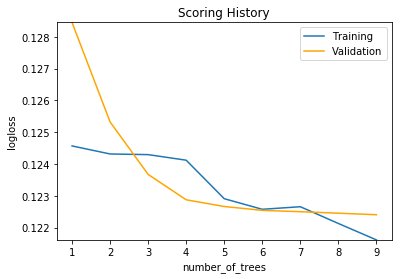

In [54]:
rf_v2.plot()

## 2.0.1 Sklearn Random Forest

In [33]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [36]:
from sklearn.ensemble import RandomForestClassifier

ModuleNotFoundError: No module named 'sklearn'

## 2.1 More exploratory based on model prediction
   * relationships between county and age
   * relationships between source and age

In [23]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


C:\Python36\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


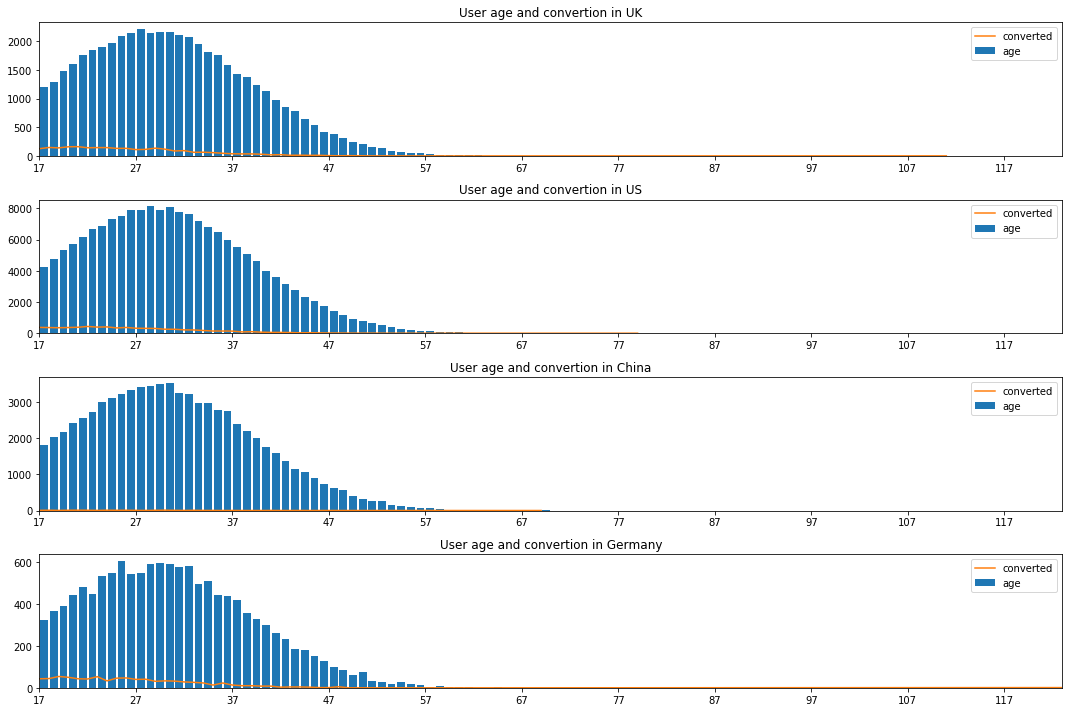

In [90]:
cty_name = df['country'].unique()
x = cty_name.size
fig, axs = plt.subplots(x,1,figsize=(15, 10), tight_layout=True)

#plot each country and their user age
for i in range(x):
    tmp_axs = axs[i]
    tmp_cty = cty_name[i]
    tmp_slice = df['country'] == tmp_cty
    tmp_converted = df[tmp_slice].groupby('age').agg({'converted':np.sum})
    tmp_bin = df['age'].max()+1 - df['age'].min()
    tmp_axs.set_title('User age and convertion in {}'.format(tmp_cty))
    tmp_axs.hist(df[tmp_slice]['age'], np.arange(df['age'].min(), df['age'].max()+1, 1), rwidth=0.8)
    tmp_axs.xaxis.set_ticks(np.arange(df['age'].min(), df['age'].max(), 10))
    tmp_axs.set_xlim([df['age'].min(),df['age'].max()])
    #tmp_axs.set_ylim([0,9000])
    # add convertion
    tmp_axs.plot(tmp_converted['converted'], linewidth = 1.5)
    tmp_axs.legend()

## 3. Result
   * Based on model, the importance of varible ranks as follows:
       * Page visited
       * New user
       * County
       * Age
       * Source
   * Among above varibles, Source are ingorable. 
   * First two variables are usage related, meaning return users or users that have been using our site heavily are most likely to convert
       * Custom stickiness is the key, we could send promotion emails to encouge return customers. For increase the usage of the first time user, we could improve our web UI to inprove user experience in order to retain them on our web page.
   * We should have different strategy on different county, age and source
       * For countries that have higher conversion rate like Germany and UK, we'd better to increase our popularity by bid heavier on search engine and Ads, since they are the first two options for user to get on our page.
       * For other countries like China and US, we have rather large user base. We should shoot for increasing conversion rate, encourage them to return
       * Need to focus on getting the younger generation, like social media, game promotion etc.